In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

import glob

Using TensorFlow backend.


In [2]:
filelist = glob.glob('ww_plots/224_224_bw/*.npy')
x = np.array([np.array(np.load(fname)) for fname in filelist])

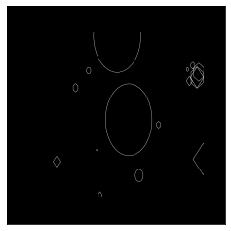

In [3]:
plt.figure(figsize=(20, 4))
ax = plt.subplot(111)
plt.imshow(x[1].reshape(x.shape[1],x.shape[2],3))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
import random 
random.shuffle(x)

X_train = x[:int(len(x)*0.8)]
X_test = x[int(len(x)*0.8):]

In [5]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [6]:
# network parameters
original_dim = X_train.shape[1]*X_train.shape[2]
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50


In [7]:
x_train = np.reshape(X_train, [-1, original_dim])
x_test = np.reshape(X_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [8]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 50176)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          25690624    encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [9]:
reconstruction_loss = mse(inputs, outputs)
#reconstruction_loss = binary_crossentropy(inputs,outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 50176)             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 25692676  
_________________________________________________________________
decoder (Model)              (None, 50176)             25741824  
Total params: 51,434,500
Trainable params: 51,434,500
Non-trainable params: 0
_________________________________________________________________


In [10]:
# train the autoencoder
vae.fit(x_train,epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))
        

Train on 23997 samples, validate on 6000 samples
Epoch 1/50
23997/23997 [==============================] - 11s 464us/step - loss: 745.9279 - val_loss: 154.1022
Epoch 2/50
23997/23997 [==============================] - 10s 427us/step - loss: 135.5711 - val_loss: 135.7524
Epoch 3/50
23997/23997 [==============================] - 10s 432us/step - loss: 134.9862 - val_loss: 130.5948
Epoch 4/50
23997/23997 [==============================] - 10s 435us/step - loss: 123.7777 - val_loss: 117.3171
Epoch 5/50
23997/23997 [==============================] - 10s 436us/step - loss: 114.8341 - val_loss: 115.0425
Epoch 6/50
23997/23997 [==============================] - 10s 436us/step - loss: 113.3328 - val_loss: 114.5615
Epoch 7/50
23997/23997 [==============================] - 10s 435us/step - loss: 112.8953 - val_loss: 114.2338
Epoch 8/50
23997/23997 [==============================] - 10s 437us/step - loss: 112.4709 - val_loss: 113.7244
Epoch 9/50
23997/23997 [==============================] - 11s 4

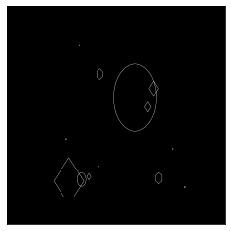

In [12]:
plt.figure(figsize=(20, 4))
ax = plt.subplot(111)
plt.imshow(X_test[1].reshape(X_train.shape[1],X_train.shape[2],3))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)

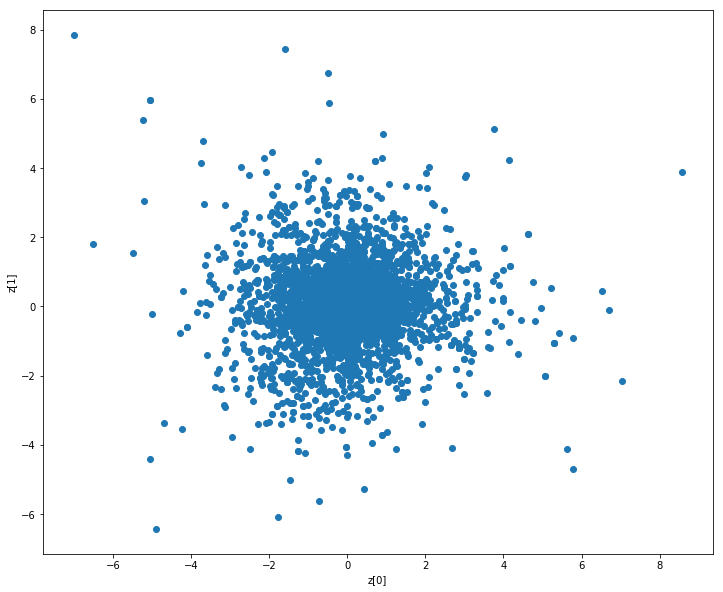

In [24]:
plt.figure(figsize=(12,10))
plt.scatter(z_mean[:, 0], z_mean[:, 1])
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


In [36]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 224
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

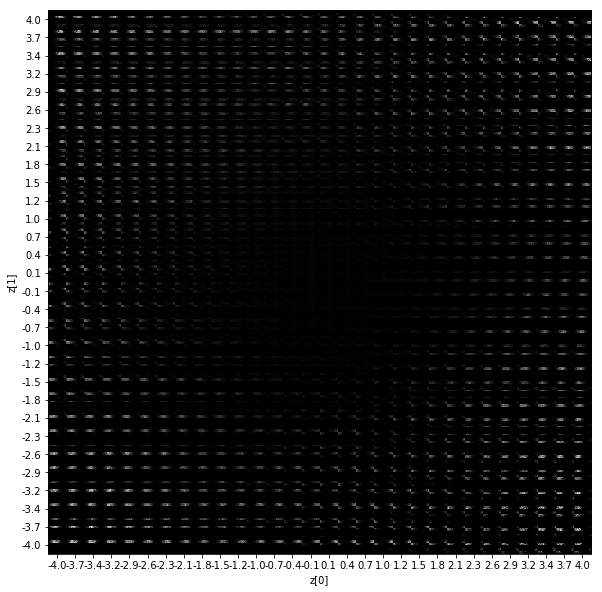

In [37]:
plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [38]:
z_sample = []
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])

In [39]:
x_decoded = decoder.predict(z_sample)

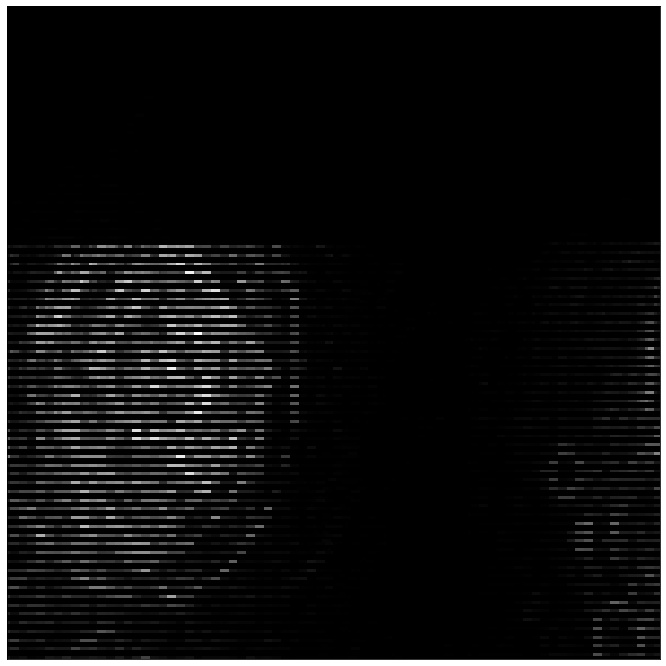

In [49]:
plt.figure(figsize=(24, 12))
ax = plt.subplot(111)
plt.imshow(x_decoded[0].reshape(digit_size, digit_size))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()